This tutorial demonstrates the use of a [3D morphable model](https://gravis.dmi.unibas.ch/publications/Sigg99/morphmod2.pdf) to fit a face to a target image. 3D reconstruction tasks are ill-posed, which means that given a single observation image, there are infinitely many possible 3D scenes that will render exactly like the observation. To resolve this people have come up with different [prior](https://en.wikipedia.org/wiki/Prior_probability) for tie-breaking between different 3D reconstructions. 3D morphable model, or 3DMM, is one of them, invented by Blanz and Vetter. The idea is to focus on one class of objects, e.g., human face. They then recruit many people (say, 200) and scan their face to construct a class of 3D models that is supposed to span the space of faces. We can then optimize for the parameters of these morphable models, so that we always end up with a plausible face.

This tutorial doesn't run on Google colab directly, since we are going to use the [Basel face model (2017 version)](http://gravis.dmi.unibas.ch/PMM/data/overview/) and it requires you to agree with their license term before using their data. Before running this tutorial, go download the model and make sure `model2017-1_bfm_nomouth.h5` is in the same directory as this file (and make sure you don't violate their license terms).

In [1]:
import torch
import pyredner
import h5py

Basel face model, like the original Blanz and Vetter model, uses a *linear basis* to represent different face geometries. They recruited 100 males and 100 females Caucasians with different ages, laser scanned their faces to produce a face triangle mesh with ~50000 triangle vertices for each person. They then perform a [principle component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) on the positions and colors on these vertices to span the face space. To sample a face in this domain, we use two vectors with size 199, one for geometry and one for color, where each coordinate correspond to the coefficient for the basis axe. Our goal is to recover the parameters for these two vectors, plus the camera pose and lighting parameters, given a single target image.

In [2]:
# Load the Basel face model
with h5py.File(r'model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(hf['shape/model/mean'], device = pyredner.get_device())
    shape_basis = torch.tensor(hf['shape/model/pcaBasis'], device = pyredner.get_device())
    triangle_list = torch.tensor(hf['shape/representer/cells'], device = pyredner.get_device())
    
    color_mean = torch.tensor(hf['color/model/mean'], device = pyredner.get_device())
    color_basis = torch.tensor(hf['color/model/pcaBasis'], device = pyredner.get_device())

Following is our model. It takes the camera parameters, PCA coefficients, and lighting parameters, and produce an image.

In [3]:
indices = triangle_list.permute(1, 0).contiguous()
def model(cam_pos, cam_look_at, shape_coeffs, color_coeffs, ambient_color, dir_light_intensity):
    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = pyredner.compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)
    m = pyredner.Material(use_vertex_color = True)
    obj = pyredner.Object(vertices = vertices, indices = indices, normals = normals, material = m, colors = colors)
    cam = pyredner.Camera(position = cam_pos,
                          look_at = cam_look_at, # Center of the vertices
                          up = torch.tensor([0.0, 1.0, 0.0]),
                          fov = torch.tensor([45.0]),
                          resolution = (256, 256))
    scene = pyredner.Scene(camera = cam, objects = [obj])
    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0]), dir_light_intensity)
    img = pyredner.render_deferred(scene = scene, lights = [ambient_light, dir_light])
    return img

Let's try to render an "average" face first and see how it looks like.

In [4]:
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277])
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918])
img = model(cam_pos, cam_look_at, torch.zeros(199, device = pyredner.get_device()),
            torch.zeros(199, device = pyredner.get_device()), torch.ones(3), torch.zeros(3))

Scene construction, time: 0.07585 s
Forward pass, time: 0.02411 s


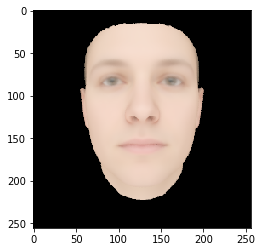

In [5]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(torch.pow(img, 1.0/2.2).cpu())

Next, let us load a target image. To avoid issues we'll use a painting (at least I hope the subject won't complain). Blanz and Vetter's paper at 1999 also use this model as a target image as one of the example.

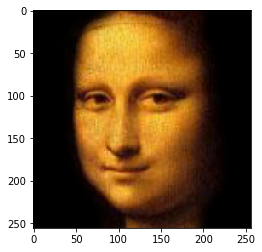

In [6]:
import urllib
urllib.request.urlretrieve('https://raw.githubusercontent.com/BachiLi/redner/master/tutorials/mona-lisa-cropped-256.png', 'target.png')
target = pyredner.imread('target.png').to(pyredner.get_device())
imshow(torch.pow(target, 1.0/2.2).cpu())

Next, let's setup the initial guess of the model.

In [33]:
# Set requires_grad=True since we want to optimize them later
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], requires_grad=True)
shape_coeffs = torch.zeros(199, device = pyredner.get_device(), requires_grad=True)
color_coeffs = torch.zeros(199, device = pyredner.get_device(), requires_grad=True)
ambient_color = torch.ones(3, device = pyredner.get_device(), requires_grad=True)
dir_light_intensity = torch.zeros(3, device = pyredner.get_device(), requires_grad=True)

In [34]:
# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam([shape_coeffs, color_coeffs, ambient_color, dir_light_intensity], lr=0.1)
cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)

We'll run an optimization loop just like the pose estimation example. In addition to the usual rendering loss, we also added a *regularization loss* that prevents the PCA coefficients from producing outlier shapes and colors (Try disabling them. You might get some interesting result...).

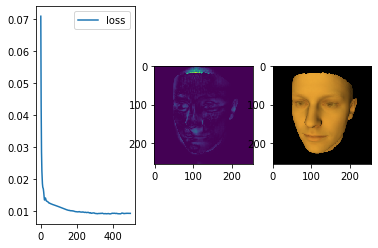

In [35]:
# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time
plt.figure()
imgs, losses = [], []
# Run 500 Adam iterations
num_iters = 500
for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()
    img = model(cam_pos, cam_look_at, shape_coeffs, color_coeffs, ambient_color, dir_light_intensity)
    # Compute the loss function. Here it is L2 plus a regularization term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space, so no gamma correction is needed.
    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()
    optimizer.step()
    cam_optimizer.step()
    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)
    # Plot the loss
    f, (ax_loss, ax_diff_img, ax_img) = plt.subplots(1, 3)
    losses.append(loss.data.item())
    # Only store images every 10th iterations
    if t % 10 == 0:
        imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) # Record the Gamma corrected image
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_diff_img.imshow((img -target).pow(2).sum(dim=2).data.cpu())
    ax_img.imshow(torch.pow(img.data.cpu(), 1.0/2.2))
    plt.show()

Now let's visualize the result:

In [36]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
# Clamp to avoid complains
im = plt.imshow(imgs[0].clamp(0.0, 1.0), animated=True)
def update_fig(i):
    im.set_array(imgs[i].clamp(0.0, 1.0))
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(imgs), interval=50, blit=True)

In [37]:
from IPython.display import HTML
HTML(anim.to_jshtml())

The result is not perfect due to several reasons: 1) Basel's face model is small and doesn't cover all possible faces. 2) The model we use focuses on neutral face expression, while Ms. Mona Lisa is smiling and looking left. 3) The painting doesn't have absolutely correct physics. 4) I didn't spend a lot of time tuning the training parameters.
You should try to play with this yourself and see if you can produce better result!